In [1]:
%matplotlib inline
from pylab import *
import matplotlib.pyplot as plt

Initialisation
==============

* importing pyAgrum
* importing pyAgrum.lib tools
* loading a BN

In [2]:
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb

## Loading two BNs

In [3]:
bn=gum.loadBN("../resources/asia.bif")
bn2=gum.loadBN("../resources/asia.bif")

gnb.showBN(bn,size="3")
gnb.showBN(bn2,size="3")

## Randomizing the parameters

In [4]:
bn.generateCPTs()
bn2.generateCPTs()

## Direct comparison of parameters

In [5]:
from IPython.display import HTML

HTML("<h3>ORIGINAL BN</h3>"+
      gnb.showPotential(bn.cpt(3),asString=True,digits=6)+
      "<h3>SCRAMBLED BN</h3>"+
      gnb.showPotential(bn2.cpt(3),asString=True,digits=6))


## Exact KL-divergence 

Since the BN is not too big, BruteForceKL can be computed ...

In [6]:
g1=gum.BruteForceKL(bn,bn2)
before_learning=g1.compute()
print(before_learning['klPQ'])

2.818698030999111


Just to be sure that the distance between a BN and itself is 0 :

In [7]:
g0=gum.BruteForceKL(bn,bn)
print(g0.compute()['klPQ'])

0.0


## Generate a database from the original BN

In [8]:
from pyAgrum.lib.bn2csv import generateCSV
generateCSV(bn,"test.csv",10000,True)

 test.csv : [ ################################################################ ] 100%
Log2-Likelihood : -63178.72305065309



-63178.72305065309

## Using pandas for counting

In [9]:
import pandas
df=pandas.read_csv('test.csv')
df

,smoking?,lung_cancer?,bronchitis?,visit_to_Asia?,tuberculosis?,tuberculos_or_cancer?,dyspnoea?,positive_XraY?
0,0,0,1,1,1,1,0,1
1,0,0,1,1,0,0,0,1
2,1,0,0,1,1,0,1,1
3,0,0,1,1,0,0,0,1
4,1,1,0,1,0,1,1,0
5,1,1,1,1,0,0,0,0
6,1,0,1,1,0,0,0,1
7,0,0,1,0,0,0,1,1
8,0,0,1,1,0,0,0,1
9,0,0,1,1,0,0,0,1


We use the crosstab function in pandas

In [10]:
c=pandas.crosstab(df['dyspnoea?'],[df['bronchitis?'],df['tuberculos_or_cancer?']])
c

bronchitis?               0          1     
tuberculos_or_cancer?     0    1     0    1
dyspnoea?                                  
0                      1045  523  2815  989
1                      1070  479  2251  828

Playing with numpy reshaping, we retrieve the good form for the CPT from the pandas cross-table

In [11]:
print("LEARNED PARAMETERS IN crosstab")
print(np.array((c/c.sum().apply(np.float32)).transpose()).reshape(2,2,2))
print
print("ORIGINAL PARAMETERS IN bn")
print(bn.cpt(bn.idFromName('dyspnoea?'))[:])

LEARNED PARAMETERS IN crosstab
[[[ 0.49408983  0.50591017]
  [ 0.52195609  0.47804391]]

 [[ 0.55566522  0.44433478]
  [ 0.5443038   0.4556962 ]]]
ORIGINAL PARAMETERS IN bn
[[[ 0.50325779  0.49674221]
  [ 0.55455788  0.44544212]]

 [[ 0.52527058  0.47472942]
  [ 0.5495918   0.4504082 ]]]


## A global method for estimating Bayesian Network parameters from CSV file using PANDAS

In [12]:
def computeCPTfromDF(bn,df,name):
    """
    Compute the CPT of variable "name" in the BN bn from the database df
    """
    id=bn.idFromName(name)
    domains=[bn.variableFromName(name).domainSize() 
             for name in bn.cpt(id).var_names]

    parents=list(bn.cpt(id).var_names)
    parents.pop()

    c=pandas.crosstab(df[name],[df[parent] for parent in parents])

    s=c.sum()
    
    # if c is monodimensionnal then s will be a float and not a Series 
    if type(s)==pandas.core.series.Series:
        s=s.apply(np.float32)
    else:
        s=float(s)
    
    bn.cpt(id)[:]=np.array((c/s).transpose()).reshape(*domains)
    
def ParametersLearning(bn,df):
    """
    Compute the CPTs of every varaible in the BN bn from the database df
    """
    for name in bn.names():
        computeCPTfromDF(bn,df,name)

In [13]:
ParametersLearning(bn2,df)

KL has decreased a lot (if everything's OK)

In [14]:
g1=gum.BruteForceKL(bn,bn2)
print("BEFORE LEARNING")
print(before_learning['klPQ'])
print
print("AFTER LEARNING")
print(g1.compute()['klPQ'])

BEFORE LEARNING
2.818698030999111
AFTER LEARNING
0.0014111343170407817


And CPTs should be close

In [15]:
HTML("<h3>ORIGINAL BN</h3>"+
      gnb.showPotential(bn.cpt(3),asString=True,digits=6)+
      "<h3>LEARNED BN</h3>"+
      gnb.showPotential(bn2.cpt(3),asString=True,digits=6))

## Influence of the size of the database on the quality of learned parameters

What is the effect of increasing the size of the database on the KL ? We expect that the KL decreases to 0.

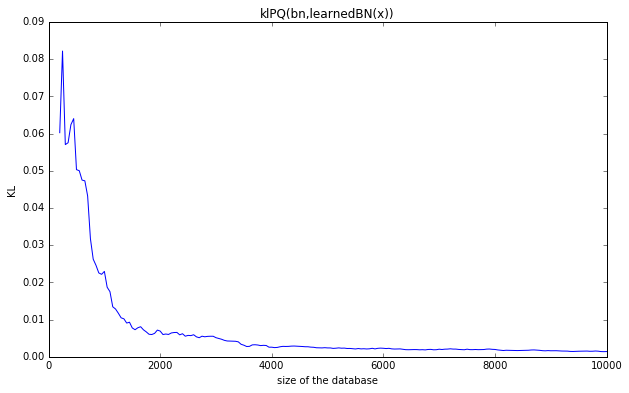

In [16]:
res=[]
for i in range(200,10001,50):
    ParametersLearning(bn2,df[:i])
    g1=gum.BruteForceKL(bn,bn2)
    res.append(g1.compute()['klPQ'])
fig=figure(figsize=(10,6))
ax  = fig.add_subplot(1, 1, 1)
ax.plot(range(200,10001,50),res)
ax.set_xlabel("size of the database")
ax.set_ylabel("KL")
t=ax.set_title("klPQ(bn,learnedBN(x))")